In [245]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

In [246]:
data = pd.read_csv("training_set.csv")

# Removing outliers (Arrival Delay of more than 100 mins)
df = data[data['ARR_DELAY'] < 100]
df = df.reset_index()

train = df.drop(['ARR_DELAY'], axis = 1)
y = df['ARR_DELAY']
df.head()

,index,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,...,FL_NUM,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,ARR_DELAY
0,0,0,2,1020,11,8,373,"2,701",11,19930,...,879,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,-11
1,1,1,6,1220,13,9,183,"1,171",5,19805,...,2491,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,1
2,2,2,6,945,48,6,355,"2,552",11,19930,...,172,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,18
3,3,3,1,1437,17,8,136,967,4,19977,...,2030,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,0
4,5,5,7,1735,28,5,151,984,4,20366,...,4220,EV,IAH,"Houston, TX",TX,MKE,"Milwaukee, WI",WI,NaN,-17


In [248]:
print "No. of outliers removed: ", len(data) - len(df)

No. of outliers removed:  149


# Data Cleaning

In [249]:
def cleaning(data):
    for i in range(len(data)):
        #print i
        data.loc[i, 'DISTANCE'] = data.loc[i, 'DISTANCE'].replace(',','')
        data.loc[i, 'DISTANCE'] = int(data.loc[i, 'DISTANCE'])

        date = data.loc[i, 'FL_DATE']
        data.loc[i, 'FL_DATE'] = datetime.datetime.strptime(date, '%Y-%m-%d')

        data.loc[i, 'DAY_OF_MONTH'] = data.loc[i, 'FL_DATE'].day
        data.loc[i, 'MONTH'] = data.loc[i, 'FL_DATE'].month

    return data

In [250]:
train = cleaning(train)
train.head()

,index,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,...,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH
0,0,0,2,1020,11,8,373,2701,11,19930,...,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,3.0,1.0
1,1,1,6,1220,13,9,183,1171,5,19805,...,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,28.0,1.0
2,2,2,6,945,48,6,355,2552,11,19930,...,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,21.0,1.0
3,3,3,1,1437,17,8,136,967,4,19977,...,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,23.0,1.0
4,5,5,7,1735,28,5,151,984,4,20366,...,EV,IAH,"Houston, TX",TX,MKE,"Milwaukee, WI",WI,NaN,1.0,1.0


# Data Pre-processing

In [251]:
def pre_processing(data):
    from sklearn.preprocessing import LabelEncoder  
    
    # Creating bins for continuous values in CRS_DEP_TIME feature
    CRS_DEP_TIME__bins = [0, 600, 1200, 1800, 2400]
    data['CRS_DEP_TIME'] = pd.cut(data['CRS_DEP_TIME'], CRS_DEP_TIME__bins)

    TAXI_OUT__bins = [0, 20, 40, 60, 80, 150]
    data['TAXI_OUT'] = pd.cut(data['TAXI_OUT'], TAXI_OUT__bins)
    
    TAXI_IN__bins = [0, 10, 20, 30, 40, 85] 
    data['TAXI_IN'] = pd.cut(data['TAXI_IN'], TAXI_IN__bins)
    
    ACTUAL_ELAPSED_TIME__bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 650]
    data['ACTUAL_ELAPSED_TIME'] = pd.cut(data['ACTUAL_ELAPSED_TIME'], ACTUAL_ELAPSED_TIME__bins)
    
    DISTANCE__bins = np.arange(0, 5100, 100)
    data['DISTANCE'] = pd.cut(data['DISTANCE'], DISTANCE__bins)
    
    # Changing string to int values
    le = LabelEncoder()
    data['ORIG_STATE'] = le.fit_transform(data['ORIGIN_STATE_ABR'])

    # Using Python's Dictionary as Hash-Map to to encode states as integers
    # Using the same encoding for Destination State as well (for consistency)
    states = {}

    for i in range(len(data)):
        key = data.loc[i, 'ORIGIN_STATE_ABR']
        value = data.loc[i, 'ORIG_STATE']
        states[key] = value

    for i in range(len(data)):
        val = data.loc[i, 'DEST_STATE_ABR']
        data.loc[i, 'DEST_STATE'] = states[val]
        data.loc[i, 'DEP_TIME'] = data.loc[i, 'CRS_DEP_TIME'].mid
        data.loc[i, 'OUT_TAXI'] = data.loc[i, 'TAXI_OUT'].mid
        data.loc[i, 'IN_TAXI'] = data.loc[i, 'TAXI_IN'].mid
        data.loc[i, 'ELAPSED_TIME'] = data.loc[i, 'ACTUAL_ELAPSED_TIME'].mid
        data.loc[i, 'NEW_DIST_GROUP'] = data.loc[i, 'DISTANCE'].mid

    return data

train = pre_processing(train)
train.head()

,index,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,...,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,0,0,2,"(600, 1200]","(0, 20]","(0, 10]","(360, 390]","(2700, 2800]",11,19930,...,NaN,3.0,1.0,47,9.0,900.0,10.0,5.0,375.0,2750.0
1,1,1,6,"(1200, 1800]","(0, 20]","(0, 10]","(180, 210]","(1100, 1200]",5,19805,...,NaN,28.0,1.0,4,42.0,1500.0,10.0,5.0,195.0,1150.0
2,2,2,6,"(600, 1200]","(40, 60]","(0, 10]","(330, 360]","(2500, 2600]",11,19930,...,NaN,21.0,1.0,0,3.0,900.0,50.0,5.0,345.0,2550.0
3,3,3,1,"(1200, 1800]","(0, 20]","(0, 10]","(120, 150]","(900, 1000]",4,19977,...,NaN,23.0,1.0,4,5.0,1500.0,10.0,5.0,135.0,950.0
4,5,5,7,"(1200, 1800]","(20, 40]","(0, 10]","(150, 180]","(900, 1000]",4,20366,...,NaN,1.0,1.0,42,48.0,1500.0,30.0,5.0,165.0,950.0


## Removing redundant features

In [252]:
# Dropping the un-cleaned columns (ONLY FOR NOW !!!)
redundant_cols = ['UID', 'FL_NUM','FIRST_DEP_TIME', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_STATE_ABR', 
                  'UNIQUE_CARRIER']
new_train = train.drop(redundant_cols, axis=1)

# These features have been used to create new features which made more sense
treated_cols = ['FL_DATE', 'ORIGIN_STATE_ABR', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'TAXI_OUT',
               'TAXI_IN', 'ACTUAL_ELAPSED_TIME', 'DISTANCE']
new_train = new_train.drop(treated_cols, axis=1)

new_train.head()

,index,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,0,2,11,19930,30559,32982,3.0,1.0,47,9.0,900.0,10.0,5.0,375.0,2750.0
1,1,6,5,19805,33570,30194,28.0,1.0,4,42.0,1500.0,10.0,5.0,195.0,1150.0
2,2,6,11,19930,30299,30466,21.0,1.0,0,3.0,900.0,50.0,5.0,345.0,2550.0
3,3,1,4,19977,32457,30325,23.0,1.0,4,5.0,1500.0,10.0,5.0,135.0,950.0
4,5,7,4,20366,31453,33342,1.0,1.0,42,48.0,1500.0,30.0,5.0,165.0,950.0


In [253]:
cols = new_train.columns.values

In [254]:
from sklearn.preprocessing import RobustScaler

RobustScaler()
scaler_x = RobustScaler().fit(new_train)
scaler_y = RobustScaler().fit(y.reshape(-1, 1))

scaled_train = scaler_x.transform(new_train)
scaled_y = scaler_y.transform(y.reshape(-1, 1))

scaled_train = pd.DataFrame(scaled_train, columns=cols)
scaled_y = pd.DataFrame(y, columns = ["ARR_DELAY"])

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [255]:
scaled_train.describe()

,index,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
count,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000,4762.000000
mean,0.000950,-0.017115,0.288324,0.187549,0.154707,0.144193,-0.002454,-0.078293,0.129196,0.129608,-0.250315,4.841453,2.201806,0.056431,0.280854
std,0.576210,0.498444,0.811021,0.742116,0.665185,0.669533,0.555578,0.576178,0.580742,0.577707,0.839533,10.026800,6.207427,0.862863,0.877853
min,-0.994324,-0.750000,-0.666667,-0.801556,-0.716286,-0.717324,-0.937500,-1.000000,-0.653846,-0.653846,-2.000000,0.000000,0.000000,-1.000000,-0.857143
25%,-0.500000,-0.500000,-0.333333,-0.029183,-0.418568,-0.418050,-0.500000,-0.500000,-0.384615,-0.384615,-1.000000,0.000000,0.000000,-0.666667,-0.428571
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.500000,0.666667,0.970817,0.581432,0.581950,0.500000,0.500000,0.615385,0.615385,0.000000,0.000000,0.000000,0.333333,0.571429
max,0.996351,0.750000,2.666667,2.657588,2.353216,2.275934,0.937500,0.833333,1.230769,1.230769,1.000000,105.000000,57.500000,4.277778,6.142857


In [256]:
cols = []
for col in scaled_train:
    cols.append(col)
    # Printing the data type of last element of every feature
    print col, "\t\t", type(scaled_train[col][len(scaled_train)-1])

index 		<type 'numpy.float64'>
DAY_OF_WEEK 		<type 'numpy.float64'>
DISTANCE_GROUP 		<type 'numpy.float64'>
AIRLINE_ID 		<type 'numpy.float64'>
ORIGIN_CITY_MARKET_ID 		<type 'numpy.float64'>
DEST_CITY_MARKET_ID 		<type 'numpy.float64'>
DAY_OF_MONTH 		<type 'numpy.float64'>
MONTH 		<type 'numpy.float64'>
ORIG_STATE 		<type 'numpy.float64'>
DEST_STATE 		<type 'numpy.float64'>
DEP_TIME 		<type 'numpy.float64'>
OUT_TAXI 		<type 'numpy.float64'>
IN_TAXI 		<type 'numpy.float64'>
ELAPSED_TIME 		<type 'numpy.float64'>
NEW_DIST_GROUP 		<type 'numpy.float64'>


# Data Distribution

### Box-Plots

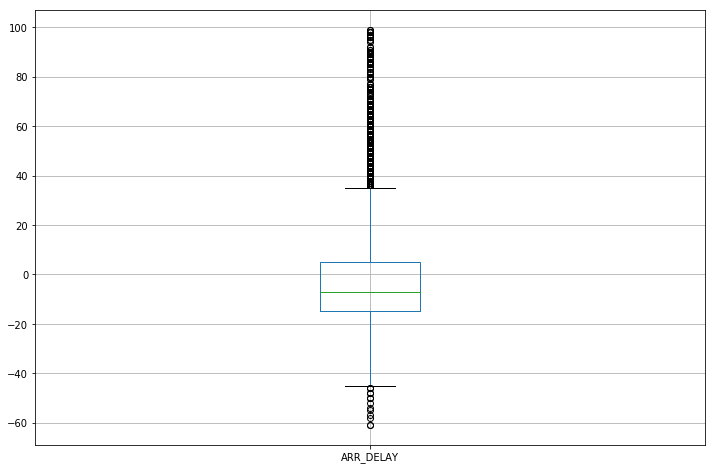

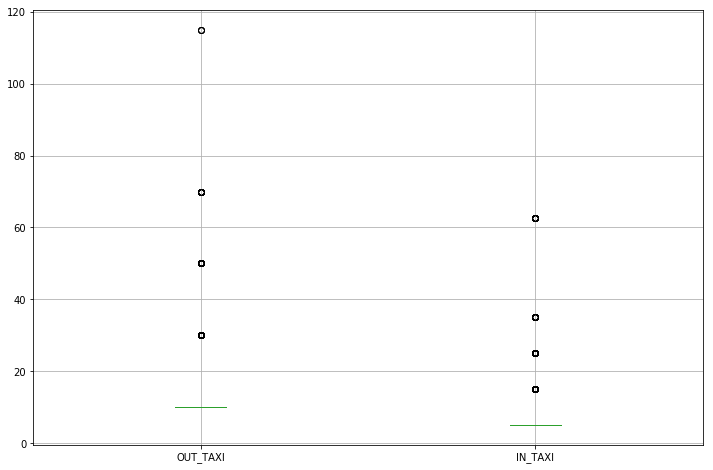

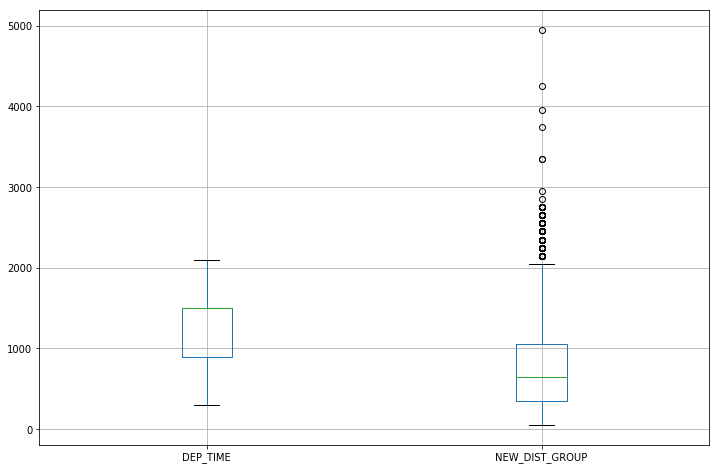

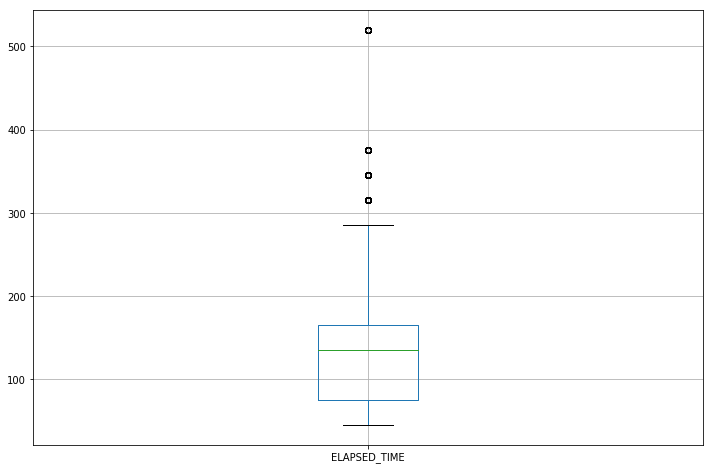

In [262]:
# Distribution of 'Arrival Delay'
ax0 = plt.figure(figsize = (12, 8))
ax0 = df.boxplot(column=['ARR_DELAY']) 

ax1 = plt.figure(figsize = (12, 8))
ax1 = new_train.boxplot(column=['OUT_TAXI', 'IN_TAXI']) 

ax2 = plt.figure(figsize = (12, 8))
ax2 = new_train.boxplot(column=['DEP_TIME', 'NEW_DIST_GROUP']) 

ax3 = plt.figure(figsize = (12, 8))
ax3 = new_train.boxplot(column=['ELAPSED_TIME']) 

### Scatter-Plots

ORIG_STATE


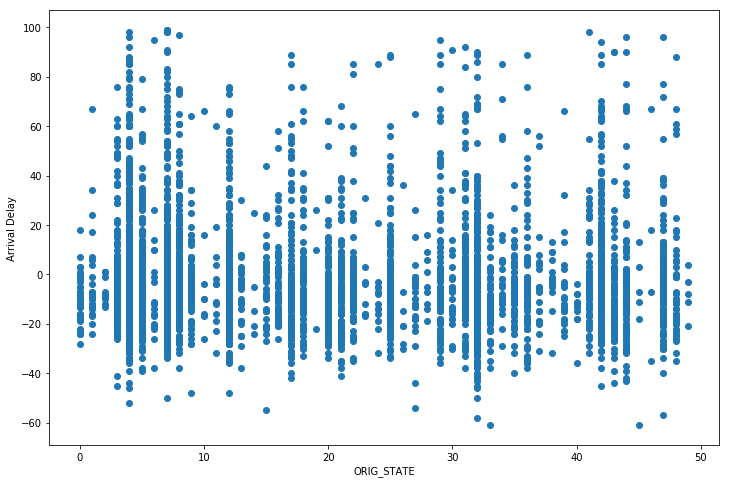

DEP_TIME


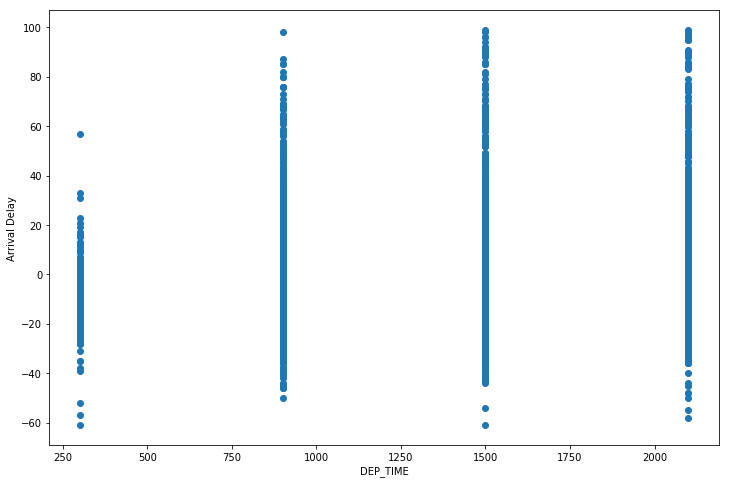

OUT_TAXI


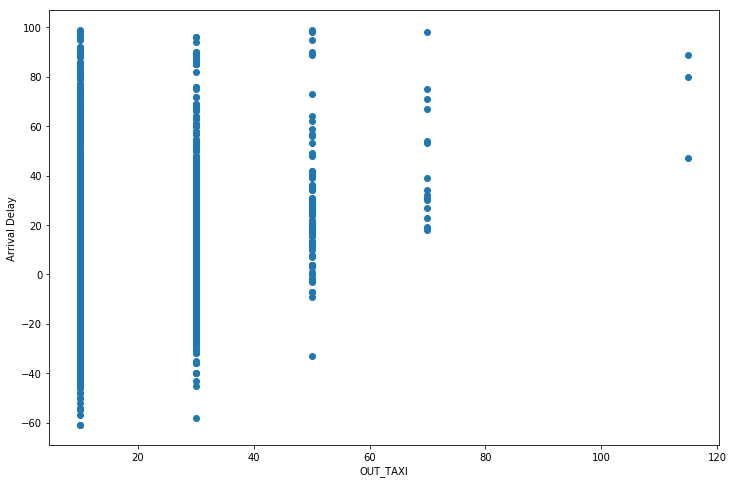

ELAPSED_TIME


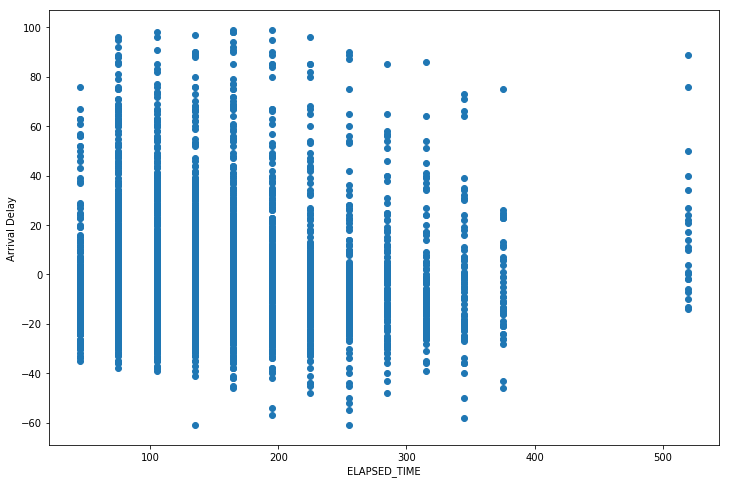

In [263]:
cols = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']
for col in cols:
    print col
    feat = train[col]
    try:
        plt.figure(figsize = (12, 8))
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

# Mutual Information

In [264]:
### Plotting function for Information Gain of each feature

def plot_info(res, title):
    
    feat = res.keys()
    imp = res.values()
    # Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(feat)), imp)
    plt.xticks(range(len(feat)), feat, rotation=40)
    plt.xlabel('Feature Name')
    plt.ylabel('Feature Importance')
    plt.title(title)
    plt.show()

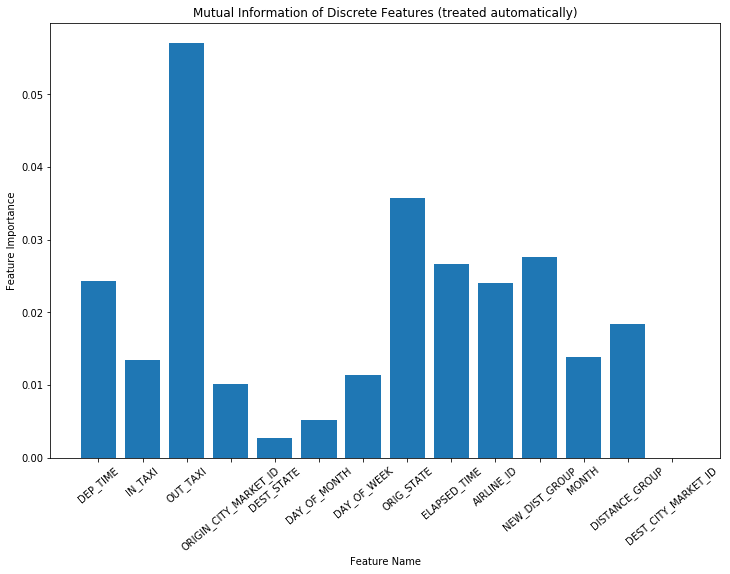

In [265]:
from sklearn.feature_selection import mutual_info_regression

discrete_feat = ['DAY_OF_WEEK', 'DISTANCE_GROUP', 'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'ORIG_STATE',
                'DAY_OF_MONTH', 'MONTH', 'DEST_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME', 
                 'AIRLINE_ID', 'NEW_DIST_GROUP']
dis_mutual_info = mutual_info_regression(scaled_train[discrete_feat], y, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated automatically)")

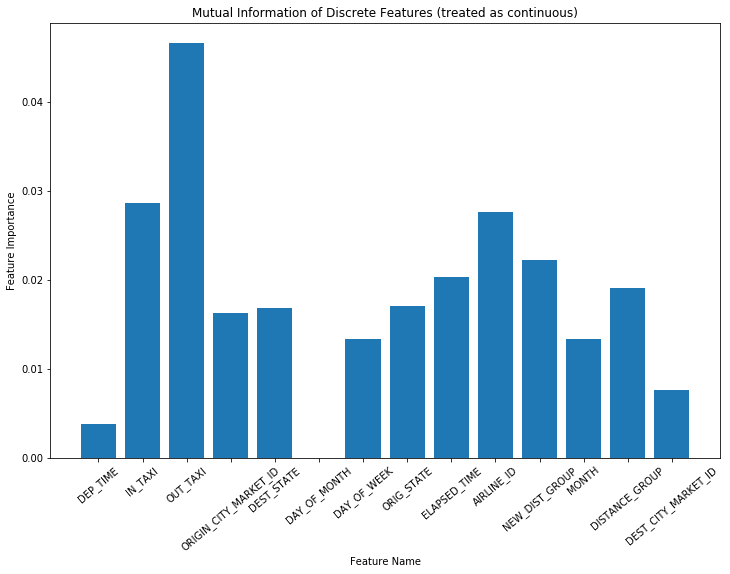

In [266]:
dis_mutual_info = mutual_info_regression(scaled_train[discrete_feat], y, discrete_features = False, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated as continuous)")

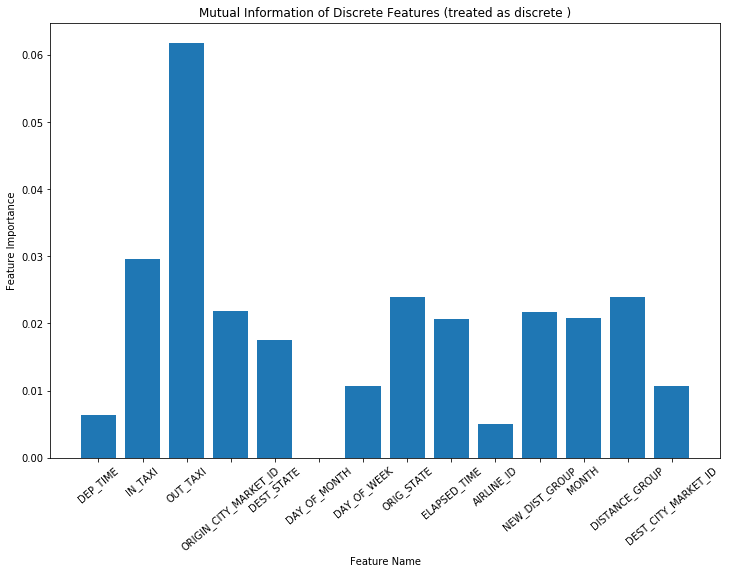

In [267]:
dis_mutual_info = mutual_info_regression(scaled_train[discrete_feat], y,   discrete_features = True, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated as discrete )")

In [116]:
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest(mutual_info_regression, k=5)
kbest.fit(scaled_train, y)
kbest.get_support(indices=True)

array([ 3,  7,  8, 11, 12])

In [117]:
i = 0
for col in scaled_train:
    print i, col
    i += 1

0 index
1 DAY_OF_WEEK
2 DISTANCE_GROUP
3 AIRLINE_ID
4 ORIGIN_CITY_MARKET_ID
5 DEST_CITY_MARKET_ID
6 DAY_OF_MONTH
7 MONTH
8 ORIG_STATE
9 DEST_STATE
10 DEP_TIME
11 OUT_TAXI
12 IN_TAXI
13 ELAPSED_TIME
14 NEW_DIST_GROUP


# Predictive Modelling

### Removing features with low Information Gain

In [119]:
bad_feat = ['DAY_OF_MONTH', 'DEST_CITY_MARKET_ID', 'index']
trimmed_train = scaled_train.drop(bad_feat, axis=1)
trimmed_train.head()

,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,-0.50,2.666667,0.243191,-0.464212,-1.0,1.153846,-0.307692,-1.0,0.0,0.0,2.666667,3.000000
1,0.50,0.666667,0.000000,1.097510,-1.0,-0.500000,0.961538,0.0,0.0,0.0,0.666667,0.714286
2,0.50,2.666667,0.243191,-0.599066,-1.0,-0.653846,-0.538462,-1.0,40.0,0.0,2.333333,2.714286
3,-0.75,0.333333,0.334630,0.520228,-1.0,-0.500000,-0.461538,0.0,0.0,0.0,0.000000,0.428571
4,0.75,0.333333,1.091440,-0.000519,-1.0,0.961538,1.192308,0.0,20.0,0.0,0.333333,0.428571


## 1. Predicting from the mean

In [177]:
#imp_feat = ['AIRLINE_ID', 'ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME']
#x = np.copy(trimmed_train[imp_feat])

# 20% split to test set as it will be used in the very end
x_train, x_test, y_train, y_test = np.array(train_test_split(new_train, y, train_size = 0.7))

y_train = np.array(y_train)
mean = y_train.mean()
#inv_scaled_mean = scaler_y.inverse_transform(mean)
preds = []

for i in range(len(y_test)):
    
    preds.append(mean)
    
#print preds
print "Mean Squared Error:", mse(y_test, preds)

Mean Squared Error: 494.848498446


# 2. Linear Regression

In [135]:
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = np.array(train_test_split(new_train, y, train_size = 0.7))

LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
preds = LR_model.predict(x_test)

MSE = mse(y_test, preds)
print MSE

390.56100688


### K-Fold Cross-Validation

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def Linear_Regression(train, y, deg, folds):
    
    MSE_stats = []

    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for tr, te in kf:
            x_train = [train[ii] for ii in tr]
            y_train = [y[ii] for ii in tr]
            x_test = [train[ii] for ii in te]
            y_test = np.array([y[ii] for ii in te])

        LR_model = Pipeline([('poly', PolynomialFeatures(degree = deg)),('linear', LinearRegression())])

        LR_model.fit(x_train, y_train)
        preds = np.array(LR_model.predict(x_test))
        #print preds
        
        #inv_scaled_pred = scaler_y.inverse_transform(preds.reshape(-1, 1))
        #inv_scaled_y = scaler_y.inverse_transform(y_test.reshape(-1, 1))
        #print preds, inv_scaled_pred

        #MSE = mse(inv_scaled_y, inv_scaled_pred)
        MSE = mse(y_test, preds)
        MSE_list.append(MSE)

        MSE_stats.append(MSE_list)
    
    return MSE_stats

#imp_feat = ['AIRLINE_ID', 'ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME',
#            'ORIGIN_CITY_MARKET_ID', 'DISTANCE_GROUP']
imp_feat = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']

train_set = np.copy(scaled_train[imp_feat])
MSE_stats = Linear_Regression(train_set, scaled_y.values, 1, 10)
print MSE_stats
np.mean(MSE_stats)

[[433.63609166562748], [478.67560370888725], [444.54435129505487], [395.18368695270919], [414.18281423788363], [434.43597096483973], [471.64269072147476], [445.93363249830929], [487.52219983442387], [410.56828933202388]]


441.6325331211234

### Degree - 2

In [160]:
MSE_stats = Linear_Regression(train_set, y.values, 2, 10)
print MSE_stats
np.mean(MSE_stats)

[[476.44295682060948], [421.29115772644445], [481.63790096034381], [454.79829590900357], [395.89825174739968], [485.18842303387368], [435.99572521962926], [432.81714244525244], [370.23017425121424], [414.27711875138942]]


436.85771468651603

### Degree - 3

In [171]:
MSE_stats = Linear_Regression(train_set, y.values, 3, 10)
print MSE_stats
np.mean(MSE_stats)

[[464.61484317371941], [450.0723505735773], [411.16878711743391], [516.92441043047791], [335.97185407597425], [438.66279254260718], [406.03730640241486], [478.70621991076496], [450.7608018655186], [398.32039610682688]]


435.12397621993148

## 3. Decision Tree

In [139]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

x_train, x_test, y_train, y_test = np.array(train_test_split(scaled_train, y, train_size = 0.7))


leaves = [1, 2, 3, 5, 7, 10, 15, 30, 50, 70, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 1000, 2000, 5000, 8000, 10000]

train_set = np.copy(scaled_train)

for i in leaves:
    
    DT_model = DecisionTreeRegressor(min_samples_leaf=i)
    DT_model.fit(x_train, y_train)
    preds = DT_model.predict(x_test)
    cv_score = cross_val_score(DT_model, train_set, y, cv = 5, scoring='neg_mean_squared_error')
    print "Leaves: ", i, "Squared error: ", -cv_score.mean()

Leaves:  1 Squared error:  888.923752061
Leaves:  2 Squared error:  775.389405153
Leaves:  3 Squared error:  698.228697166
Leaves:  5 Squared error:  613.68335619
Leaves:  7 Squared error:  565.201782058
Leaves:  10 Squared error:  525.081085038
Leaves:  15 Squared error:  496.153143439
Leaves:  30 Squared error:  457.599896676
Leaves:  50 Squared error:  440.535031926
Leaves:  70 Squared error:  435.490161757
Leaves:  100 Squared error:  443.041055254
Leaves:  200 Squared error:  443.743308511
Leaves:  500 Squared error:  448.197877018
Leaves:  1000 Squared error:  477.926014652
Leaves:  2000 Squared error:  483.163023421
Leaves:  3000 Squared error:  483.163023421
Leaves:  4000 Squared error:  483.163023421
Leaves:  5000 Squared error:  483.163023421
Leaves:  1000 Squared error:  477.926014652
Leaves:  2000 Squared error:  483.163023421
Leaves:  5000 Squared error:  483.163023421
Leaves:  8000 Squared error:  483.163023421
Leaves:  10000 Squared error:  483.163023421


### Information Gain from Decision Tree

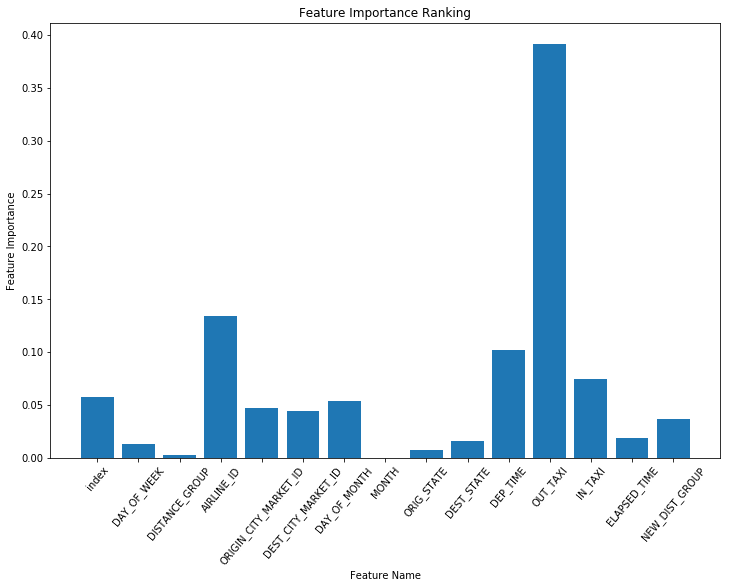

In [140]:
DT_model = DecisionTreeRegressor(min_samples_leaf=50)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( scaled_train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

# 4. Random Forest Regressor

In [162]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor

def kfold_random_forest(train, y, trees, folds, msl):
    
    MSE_stats = pd.DataFrame()
    R2_stats = pd.DataFrame()
    
    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for train, test in kf:
            x_train = [train_set[ii] for ii in train]
            y_train = [y[ii] for ii in train]
            x_test = [train_set[ii] for ii in test]
            y_test = np.array([y[ii] for ii in test])

        for i in trees:
            RF_model = RandomForestRegressor(n_estimators=i, min_samples_leaf=msl)
            RF_model.fit(x_train, y_train)
            preds = RF_model.predict(x_test)
                    
            # Scaling back the predictions before caclulating the Mean-Squared Error
            #inv_scaled_pred = scaler_y.inverse_transform(preds.reshape(-1, 1))
            #inv_scaled_y = scaler_y.inverse_transform(y_test.reshape(-1, 1))
            
            MSE = mse(y_test, preds)
            #MSE = mse(inv_scaled_y, inv_scaled_pred)
            MSE_list.append(MSE)

        MSE_stats[j] = MSE_list
    
    return MSE_stats

In [163]:
#train_set = np.copy(scaled_train)

trees = [5, 10, 30, 50, 80, 100, 200, 500, 1000]
msl = [20, 50, 100, 200, 300, 400, 500, 800]

for ms in msl:   
    print "\nMin_samples_leaf: ", ms
    MSE_stats = kfold_random_forest(train_set, scaled_y.values, trees, 5, ms)

    kfold_mean_MSE = {}

    for i in range(len(trees)):
        print "Trees:", trees[i]

        kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
        print "\tMSE:", kfold_mean_MSE[i]


Min_samples_leaf:  20


/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Trees: 5
	MSE: 432.766149866
Trees: 10
	MSE: 432.768598645
Trees: 30
	MSE: 428.508614735
Trees: 50
	MSE: 429.225268849
Trees: 80
	MSE: 428.258649732
Trees: 100
	MSE: 427.063612915
Trees: 200
	MSE: 427.213530414
Trees: 500
	MSE: 427.10765416
Trees: 1000
	MSE: 427.131247093

Min_samples_leaf:  50
Trees: 5
	MSE: 423.97849561
Trees: 10
	MSE: 423.225280727
Trees: 30
	MSE: 422.228419524
Trees: 50
	MSE: 422.171802299
Trees: 80
	MSE: 421.954123436
Trees: 100
	MSE: 423.200102414
Trees: 200
	MSE: 422.588432376
Trees: 500
	MSE: 422.483332137
Trees: 1000
	MSE: 422.224178497

Min_samples_leaf:  100
Trees: 5
	MSE: 447.440405256
Trees: 10
	MSE: 445.502709376
Trees: 30
	MSE: 444.414354504
Trees: 50
	MSE: 444.663034093
Trees: 80
	MSE: 444.845361764
Trees: 100
	MSE: 444.905553708
Trees: 200
	MSE: 444.66727621
Trees: 500
	MSE: 444.676772544
Trees: 1000
	MSE: 444.558600018

Min_samples_leaf:  200
Trees: 5
	MSE: 425.07567899
Trees: 10
	MSE: 424.013027858
Trees: 30
	MSE: 424.664724501
Trees: 50
	MSE: 424.46

# Support Vector Machines

In [164]:
from sklearn.svm import SVR
from sklearn.cross_validation import KFold

def kfold_SVM(train_set, y, kernels, folds):

    MSE_stats = pd.DataFrame()
    
    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train_set), n_folds = folds, shuffle=True) 

        for train, test in kf:
            
            x_train = [train_set[ii] for ii in train]
            y_train = [y[ii] for ii in train]
            x_test = [train_set[ii] for ii in test]
            y_test = [y[ii] for ii in test]
            
        for i in kernels:
            SVM_model = SVR(kernel = i, epsilon = 0.1, degree=2)
            SVM_model.fit(x_train, y_train)
            preds = SVM_model.predict(x_test)

            #inv_scaled_pred = scaler_y.inverse_transform(preds.reshape(-1, 1))
            #inv_scaled_y = scaler_y.inverse_transform(y_test)

            MSE = mse(y_test, preds)
            MSE_list.append(MSE)

        MSE_stats[j] = MSE_list
    
    return MSE_stats

In [165]:
#imp_feat = ['AIRLINE_ID', 'ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME',
#           'ORIGIN_CITY_MARKET_ID', 'DISTANCE_GROUP']
imp_feat = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']

train_set = np.copy(trimmed_train[imp_feat])

#kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kernels = ['linear', 'rbf', 'sigmoid']

folds = 8
MSE_stats = kfold_SVM(train_set, np.copy(y), kernels, folds)

kfold_mean_MSE = {}

for i in range(len(kernels)):
    print "Kernel:", kernels[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]

Kernel: linear
	MSE: 426.388074362
Kernel: rbf
	MSE: 434.25874652
Kernel: sigmoid
	MSE: 3954.17331934


# Random Forests to Predict from Test Set

In [200]:
x_test = pd.read_csv("testing_set.csv")
#imp_feat = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']
ID_set = x_test['UID']
#x_test = x_test[imp_feat]

In [201]:
def test_pre_processing(data):
    from sklearn.preprocessing import LabelEncoder  
    
    # Creating bins for continuous values in CRS_DEP_TIME feature
    CRS_DEP_TIME__bins = [0, 600, 1200, 1800, 2400]
    data['CRS_DEP_TIME'] = pd.cut(data['CRS_DEP_TIME'], CRS_DEP_TIME__bins)

    TAXI_OUT__bins = [0, 20, 40, 60, 80, 150]
    data['TAXI_OUT'] = pd.cut(data['TAXI_OUT'], TAXI_OUT__bins)
    
    TAXI_IN__bins = [0, 10, 20, 30, 40, 85] 
    data['TAXI_IN'] = pd.cut(data['TAXI_IN'], TAXI_IN__bins)
    
    ACTUAL_ELAPSED_TIME__bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 650]
    data['ACTUAL_ELAPSED_TIME'] = pd.cut(data['ACTUAL_ELAPSED_TIME'], ACTUAL_ELAPSED_TIME__bins)
    
    DISTANCE__bins = np.arange(0, 5100, 100)
    data['DISTANCE'] = pd.cut(data['DISTANCE'], DISTANCE__bins)
    
    # Changing string to int values
    le = LabelEncoder()
    data['ORIG_STATE'] = le.fit_transform(data['ORIGIN_STATE_ABR'])

    # Using Python's Dictionary as Hash-Map to to encode states as integers
    # Using the same encoding for Destination State as well (for consistency)
    states = {}

    for i in range(len(data)):
        key = data.loc[i, 'ORIGIN_STATE_ABR']
        value = data.loc[i, 'ORIG_STATE']
        states[key] = value
        data.loc[i, 'DEP_TIME'] = data.loc[i, 'CRS_DEP_TIME'].mid
        data.loc[i, 'OUT_TAXI'] = data.loc[i, 'TAXI_OUT'].mid
        data.loc[i, 'IN_TAXI'] = data.loc[i, 'TAXI_IN'].mid
        data.loc[i, 'ELAPSED_TIME'] = data.loc[i, 'ACTUAL_ELAPSED_TIME'].mid
        data.loc[i, 'NEW_DIST_GROUP'] = data.loc[i, 'DISTANCE'].mid

    return data

In [202]:
x_test = cleaning(x_test)
x_test = test_pre_processing(x_test)
x_test.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,DEST_STATE_ABR,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH,ORIG_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,8,3,"(1800, 2400]","(0, 20]","(0, 10]","(60, 90]","(300, 400]",2,20304,2017-01-25 00:00:00,...,CA,NaN,25.0,1.0,4,2100.0,10.0,5.0,75.0,350.0
1,15,2,"(1800, 2400]","(0, 20]","(0, 10]","(180, 210]","(1400, 1500]",6,19393,2017-01-10 00:00:00,...,TX,NaN,10.0,1.0,4,2100.0,10.0,5.0,195.0,1450.0
2,29,2,"(1200, 1800]","(0, 20]","(0, 10]","(120, 150]","(700, 800]",4,20366,2017-01-17 00:00:00,...,GA,NaN,17.0,1.0,27,1500.0,10.0,5.0,135.0,750.0
3,33,1,"(600, 1200]","(0, 20]","(0, 10]","(90, 120]","(700, 800]",4,19790,2017-01-09 00:00:00,...,FL,NaN,9.0,1.0,14,900.0,10.0,5.0,105.0,750.0
4,65,6,"(1200, 1800]","(0, 20]","(0, 10]","(270, 300]","(2400, 2500]",10,21171,2017-01-07 00:00:00,...,VA,NaN,7.0,1.0,4,1500.0,10.0,5.0,285.0,2450.0


In [204]:
from sklearn.preprocessing import RobustScaler

imp_feat = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']

x_test = x_test[imp_feat]

RobustScaler()
scaler_test = RobustScaler().fit(x_test)

scaled_test = scaler_test.transform(x_test)
scaled_test = pd.DataFrame(scaled_test, columns=imp_feat)
scaled_test.head()

,ORIG_STATE,DEP_TIME,OUT_TAXI,ELAPSED_TIME
0,-0.521739,0.5,0.0,-0.333333
1,-0.521739,0.5,0.0,1.000000
2,0.478261,0.0,0.0,0.333333
3,-0.086957,-0.5,0.0,0.000000
4,-0.521739,0.0,0.0,2.000000


In [244]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators=80, min_samples_leaf=50)
RF_model.fit(train_set, scaled_y.values)

preds_train = RF_model.predict(train_set)
print i, "Training MSE:", mse(scaled_y.values, preds_train)    

preds_test = RF_model.predict(scaled_test)
print preds_test
preds_test = pd.DataFrame(preds_test)
preds_test.to_csv("predicted labels.csv")
ID_set.to_csv("ID_SET.csv")

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


1428 Training MSE: 415.560088782
[ -0.75320872  -3.55957879  -1.59914663  -7.89659178  -3.29587098
  -4.09499173  -6.85257586  -0.75320872  -4.09499173  -8.35851158
  -3.29587098   1.48110645  -4.1386149    4.931851   -10.05718675
  -5.29195619  -3.86580475  -0.75320872  -5.66704621  -4.94203183
   0.13394415  -0.75320872   5.58722594  11.10390317  -6.11440515
   4.56292777   1.79106306  -3.64188063  -5.93848456   3.71930357
   1.39499559  -3.22877472  -7.16518205  -3.45668375   2.63609438
  -3.64188063  -3.24822794  -6.98764038  -8.39360319 -10.08661982
  -8.69137146  -9.81506643   1.91003136  -7.98857891  -6.08911153
  -4.20278472  -4.47898382  -4.33820827  -5.5134653   -2.64023181
  -8.03251097   2.39741824  12.22319841  -4.34576287  -7.67137242
  -4.83989417  -3.93202998   8.05611133  -4.91522409  -4.51531945
   4.79367039  30.19443413  -4.83989417  -4.76477784  -1.10006849
  -3.64188063  -3.91797233  -4.32598092  -6.98764038  -3.29587098
  -4.20933012   6.52703524   4.29137094   8